In [1]:
from gvuln import *
import matplotlib.pyplot as plt
from time import time 

torch.set_default_dtype(torch.float32)

# Geo-indistinguishability

### Black-box Estimation

In [12]:
def original_model(batch_size=10, eps=0.1):

    x = distributions.Normal(0., 10.).sample([batch_size, 1])
    y = distributions.Normal(0., 20.).sample([batch_size, 1])

    r = distributions.Gamma(2., eps).sample([batch_size, 1])

    theta = distributions.Uniform(0., 2*torch.pi).sample([batch_size, 1])

    x_anon = r*torch.cos(theta) + x
    y_anon = r*torch.sin(theta) + y

    return x, y, x_anon, y_anon

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
from sklearn.neighbors import KNeighborsRegressor
import numpy as np

def custom_loss(y_true, y_pred):
    y_true = torch.tensor(y_true)
    y_pred = torch.tensor(y_pred)
    return torch.mean(torch.exp(-0.5 * torch.sum((y_true - y_pred) ** 2, dim=1)))

train_size = 100_000
test_size = 10_000
n_neighbors = 100

eps_list = torch.tensor([0.1, 0.5, 1., 2., 5., 10.])

x = torch.linspace(0, 10, 100)

gvuln_bbox = {}

for eps in eps_list:

    gvuln_bbox[eps.item()] = []

    for i in range(10):

        # creates data for training
        x, y, x_anon, y_anon = original_model(batch_size=train_size, eps=eps)
        output_train = torch.hstack([x, y])
        input_train = torch.hstack([x_anon, y_anon])

        # creates data for testing
        x, y, x_anon, y_anon = original_model(batch_size=test_size, eps=eps)
        output_test = torch.hstack([x, y])
        input_test = torch.hstack([x_anon, y_anon])

        # Fit KNN regressor
        knn = KNeighborsRegressor(n_neighbors=n_neighbors)
        knn.fit(output_train, input_train)  # reshape if o_train is 1D

        # Predict for test set
        input_pred = knn.predict(output_test)

        loss = custom_loss(input_test, input_pred)

        gvuln_bbox[eps.item()].append(loss.item())

    print('Eps: ', eps.item(), 'Loss: ', np.mean(gvuln_bbox[eps.item()]), '+-', np.std(gvuln_bbox[eps.item()]))

Eps:  0.10000000149011612 Loss:  0.008075692132115364 +- 0.0006467087523550737
Eps:  0.5 Loss:  0.13574071377515792 +- 0.002478505602310252
Eps:  1.0 Loss:  0.33407695293426515 +- 0.003244090486566908
Eps:  2.0 Loss:  0.6113718569278717 +- 0.0031097493872866188
Eps:  5.0 Loss:  0.8767650961875916 +- 0.0016904449048009257
Eps:  10.0 Loss:  0.9464595198631287 +- 0.0013080387362348087


In [26]:
from sklearn.feature_selection import mutual_info_regression

train_size = 1_000_000

mix_bbox = {}
miy_bbox = {}

for eps in eps_list:

    mix_bbox[eps.item()] = []
    miy_bbox[eps.item()] = []

    for i in range(10):

        # creates data for training
        x, y, x_anon, y_anon = original_model(batch_size=train_size, eps=eps)
        x = x.numpy().flatten()
        y = y.numpy().flatten()
        x_anon = x_anon.numpy().flatten()
        y_anon = y_anon.numpy().flatten()

        mi_x = mutual_info_regression(x.reshape(-1, 1), x_anon)
        mi_y = mutual_info_regression(y.reshape(-1, 1), y_anon)

        mix_bbox[eps.item()].append(mi_x[0])
        miy_bbox[eps.item()].append(mi_y[0])


for eps in eps_list:
    print('Eps: ', eps.item(), 'MI X: ', np.mean(mix_bbox[eps.item()]), '+-', np.std(mix_bbox[eps.item()]))

for eps in eps_list:
    print('Eps: ', eps.item(), 'MI Y: ', np.mean(miy_bbox[eps.item()]), '+-', np.std(miy_bbox[eps.item()]))

Eps:  0.10000000149011612 MI X:  0.1686269601682059 +- 0.0007676342887441166
Eps:  0.5 MI X:  1.155374994484189 +- 0.000896229608948517
Eps:  1.0 MI X:  1.806204163991802 +- 0.0013298052192135291
Eps:  2.0 MI X:  2.4895011309763704 +- 0.0013600445088818843
Eps:  5.0 MI X:  3.4020701179012014 +- 0.0015307639837258994
Eps:  10.0 MI X:  4.095506957793374 +- 0.0013824265507821414
Eps:  0.10000000149011612 MI Y:  0.46004752874352156 +- 0.0012804608476168057
Eps:  0.5 MI Y:  1.8056941132897513 +- 0.0015816238777974503
Eps:  1.0 MI Y:  2.4895223471641588 +- 0.001016936117096106
Eps:  2.0 MI Y:  3.178988018496823 +- 0.001007770377519627
Eps:  5.0 MI Y:  4.096110259821215 +- 0.001842586576205974
Eps:  10.0 MI Y:  4.789686207122431 +- 0.001082250354683616


## Without Loops

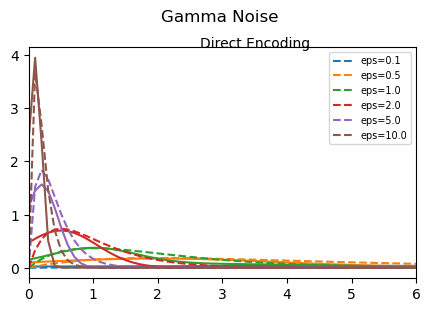

In [25]:
import matplotlib.pyplot as plt
from itertools import cycle

color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

plt.figure(figsize=(5, 3))

mean = torch.tensor(2.)

eps_list = torch.tensor([0.1, 0.5, 1., 2., 5., 10.])


x = torch.linspace(0, 10, 100)

for eps in eps_list:

    # SOGA approximation
    program = 'noise = gm([_p1, _p2], [_mu1, _mu2], [_sigma1, _sigma2]);'
    compiledFile=compile2SOGA_text(program)
    cfg = produce_cfg_text(compiledFile)
    mean = torch.tensor(2.)
    scale = 1/eps
    _, pi1, pi2, mu1, mu2, sigma1, sigma2 = fit_gamma(mean, scale)
    pars = {'p1': pi1,
            'p2': pi2,
            'mu1': mu1,
            'mu2': mu2,
            'sigma1': sigma1,
            'sigma2': sigma2
            }
    params_dict = {}
    for key, value in pars.items():
        params_dict[key] = torch.tensor(value.item(), requires_grad=True)    
    output_dist = start_SOGA(cfg, params_dict=params_dict)
    y_soga = output_dist.gm.pdf(x.reshape(-1, 1)).detach().numpy()

    y = Gamma(mean, eps).log_prob(x).exp()

    color = next(color_cycle)

    plt.plot(x.numpy(), y_soga, color=color)
    plt.plot(x.numpy(), y.numpy(), ls='--', label='eps={}'.format(round(eps.item(),2)), color=color)

plt.title('Gamma Noise \n')
plt.text(3.5, 4.35, 'Direct Encoding', ha='center', va='top')
plt.xlim(0,6)
plt.legend(fontsize=7)

In [26]:
torch.manual_seed(100)

In [2]:
vdelta_noloop_lb = {}
vdelta_noloop_ub = {}
vgauss_noloop_lb = {}
vgauss_noloop_ub = {}
vdelta_noloop = {}
vgauss_noloop = {}

cond_ent_noloop_lb = {}
cond_ent_noloop_ub = {}
cond_ent_noloop = {}

mi_noloop_lb = {}
mi_noloop_ub = {}
mi_noloop = {}

kl_noloop_lb = {}
kl_noloop_ub = {}
kl_noloop = {}

n_samples = 100_000
sampling_time = 0.
bounds_time = 0.

eps_list = torch.tensor([0.1, 0.5, 1., 2., 5., 10.])

for eps in eps_list:

    print('\n Eps = {}'.format(eps))

    # Computing noise    
    mean = torch.tensor(2.)
    scale = 1/eps

    _, pi1, pi2, mu1, mu2, sigma1, sigma2 = fit_gamma(mean, scale)

    pars = {'p1': pi1,
            'p2': pi2,
            'mu1': mu1,
            'mu2': mu2,
            'sigma1': sigma1,
            'sigma2': sigma2
            }
    params_dict = {}
    for key, value in pars.items():
        params_dict[key] = torch.tensor(value.item(), requires_grad=True)    

    # Computing SOGA output
    compiledFile=compile2SOGA('Geo_ind.soga')
    cfg = produce_cfg(compiledFile)
    output_dist = start_SOGA(cfg, params_dict=params_dict)
    marg_dist = extract_marginal(output_dist, ['x', 'y', 'xAnon', 'yAnon'])
    marg_dist = aggregate_mixture(marg_dist)
    s_marg = extract_marginal(output_dist, ['x', 'y'])
    s_marg = aggregate_mixture(s_marg)

    compiledFile=compile2SOGA('Geo_ind_obs.soga')
    cfg = produce_cfg(compiledFile)
    output_dist = start_SOGA(cfg, params_dict=params_dict)
    s_marg_obs = extract_marginal(output_dist, ['x', 'y'])
    s_marg_obs = aggregate_mixture(s_marg_obs)

    # Computing bounds
    start = time()
    vdelta_noloop_lb['{}'.format(eps)] = vdelta_lower_bound(marg_dist, idx_o=[2,3], mvariate=True)
    vdelta_noloop_ub['{}'.format(eps)] = vdelta_upper_bound(marg_dist, idx_o=[2,3], mvariate=True)
    vgauss_noloop_lb['{}'.format(eps)] = vgauss_lower_bound(marg_dist, idx_o=[2,3], eps=1., mvariate=True)
    vgauss_noloop_ub['{}'.format(eps)] = vgauss_upper_bound(marg_dist, idx_o=[2,3], eps=1., mvariate=True)
    
    cond_ent_noloop_lb['{}'.format(eps)] = cond_entropy_lb(marg_dist, idx_o=[2,3])
    cond_ent_noloop_ub['{}'.format(eps)] = cond_entropy_ub(marg_dist, idx_o=[2,3])
    
    mi_noloop_lb['{}'.format(eps)] = mi_lb(marg_dist, idx_o=[2,3])
    mi_noloop_ub['{}'.format(eps)] = mi_ub(marg_dist, idx_o=[2,3])

    kl_noloop_lb['{}'.format(eps)] = kl_div_lb(s_marg_obs, s_marg)
    kl_noloop_ub['{}'.format(eps)] = kl_div_ub(s_marg_obs, s_marg)
    end = time()
    print('Eps {} took {:.2f} seconds to compute bounds'.format(eps, end-start))
    bounds_time += end - start

    # Computing exact values with MCMC
    start = time()
    vdelta_noloop['{}'.format(eps)] = sample_gvuln_multivariate(marg_dist, n_samples=1000, secret_var=['x', 'y'], output_var=['xAnon', 'yAnon'], gain_type='delta', lr=0.001)
    vgauss_noloop['{}'.format(eps)] = sample_gvuln_multivariate(marg_dist, n_samples=1000, secret_var=['x', 'y'], output_var=['xAnon', 'yAnon'], gain_type='gauss', lr=0.001)
    
    cond_ent_noloop['{}'.format(eps)] = sample_cond_entropy(marg_dist, idx_o=[2,3], n_samples=n_samples)
    mi_noloop['{}'.format(eps)] = sample_mi(marg_dist, idx_o=[2,3], n_samples=n_samples)
    kl_noloop['{}'.format(eps)] = sample_kl(s_marg_obs, s_marg, n_samples=n_samples)
    end = time()
    print('Eps {} took {:.2f} seconds to sample'.format(eps, end-start))
    sampling_time += end - start

print('\nBounds time: {:.2f} seconds'.format(bounds_time))
print('Sampling time: {:.2f} seconds'.format(sampling_time))


 Eps = 0.10000000149011612
Eps 0.10000000149011612 took 0.13 seconds to compute bounds
Returning after 5 samples
Total time for conditioning: 0.01s
Total time for maximizing: 23.43s
Returning after 5 samples
Total time for conditioning: 0.01s
Total time for maximizing: 12.65s
Eps 0.10000000149011612 took 36.54 seconds to sample

 Eps = 0.5
Eps 0.5 took 0.11 seconds to compute bounds
Returning after 5 samples
Total time for conditioning: 0.01s
Total time for maximizing: 24.09s
Returning after 6 samples
Total time for conditioning: 0.01s
Total time for maximizing: 14.95s
Eps 0.5 took 39.41 seconds to sample

 Eps = 1.0
Eps 1.0 took 0.11 seconds to compute bounds
Returning after 5 samples
Total time for conditioning: 0.01s
Total time for maximizing: 22.72s
Returning after 5 samples
Total time for conditioning: 0.00s
Total time for maximizing: 12.22s
Eps 1.0 took 35.33 seconds to sample

 Eps = 2.0
Eps 2.0 took 0.09 seconds to compute bounds
Returning after 5 samples
Total time for condit

In [3]:
print('Delta Gain')
for key in vdelta_noloop_lb.keys():
    print('\t Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), vdelta_noloop_lb[key], vdelta_noloop[key], vdelta_noloop_ub[key]))

print('\n Gauss Gain')
for key in vgauss_noloop_lb.keys():
    print('\t Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), vgauss_noloop_lb[key], vgauss_noloop[key], vgauss_noloop_ub[key]))

print('\n Conditional Entropy')
for key in cond_ent_noloop_lb.keys():
    print('\t Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), cond_ent_noloop_lb[key], cond_ent_noloop[key], cond_ent_noloop_ub[key]))

print('\n Mutual Information')
for key in mi_noloop_lb.keys():
    print('\t Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), mi_noloop_lb[key], mi_noloop[key], mi_noloop_ub[key]))

print('\n KL Divergence')
for key in kl_noloop_lb.keys():
    print('\t Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), kl_noloop_lb[key], kl_noloop[key], kl_noloop_ub[key]))


Delta Gain
	 Eps = 0.1, lb = 0.001467, exact=0.002031, ub= 0.002943
	 Eps = 0.5, lb = 0.021571, exact=0.029134, ub= 0.044539
	 Eps = 1.0, lb = 0.081921, exact=0.106518, ub= 0.182266
	 Eps = 2.0, lb = 0.345504, exact=0.490739, ub= 0.691051
	 Eps = 5.0, lb = 1.837116, exact=3.010174, ub= 3.674484
	 Eps = 10.0, lb = 10.099828, exact=15.090132, ub= 20.200558

 Gauss Gain
	 Eps = 0.1, lb = 0.009048, exact=0.012578, ub= 0.018147
	 Eps = 0.5, lb = 0.099326, exact=0.146915, ub= 0.207130
	 Eps = 1.0, lb = 0.168196, exact=0.337611, ub= 0.430306
	 Eps = 2.0, lb = 0.403088, exact=0.743546, ub= 0.806442
	 Eps = 5.0, lb = 0.474638, exact=0.936111, ub= 0.950638
	 Eps = 10.0, lb = 0.491167, exact=0.981776, ub= 0.985947

 Conditional Entropy
	 Eps = 0.1, lb = 5.718503, exact=7.026937, ub= 7.842621
	 Eps = 0.5, lb = 2.841667, exact=4.934689, ub= 6.017693
	 Eps = 1.0, lb = 1.570395, exact=3.763851, ub= 4.896046
	 Eps = 2.0, lb = 0.260511, exact=1.665428, ub= 2.466168
	 Eps = 5.0, lb = -1.443559, exact=-0

## Rejection Sampling Loop 

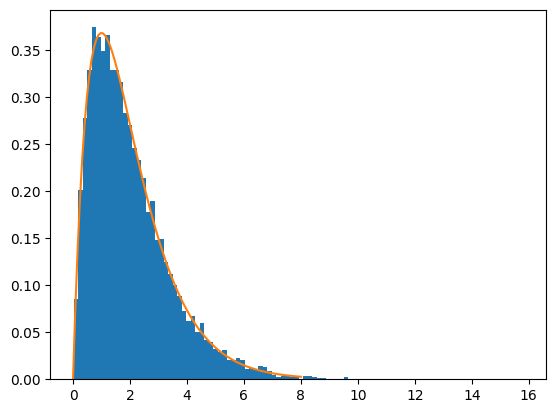

In [5]:
from torch.distributions import Uniform

def rejection_sampling():
    while True:
        w = Uniform(0,10).sample()
        u = Uniform(0,1).sample()
        if u <= torch.exp(-w):
            return w
        
def rejection_sampling_rewrite():
    w = Uniform(0,10).sample()
    u = Uniform(0,1).sample()
    while u > torch.exp(-w):
        w = Uniform(0,20).sample()
        u = Uniform(0,1).sample()
    return w

def gamma_sampling(mean, scale):
    sum_exps = torch.tensor(0.)
    for _ in range(mean):
        sum_exps += rejection_sampling_rewrite()
    return sum_exps / scale

mean = torch.tensor(2)
scale = torch.tensor(1.0)

samples = []
for i in range(10000):
    samples.append(gamma_sampling(mean, scale))

x = torch.linspace(0, 8, 100)
y = torch.distributions.Gamma(mean, 1/scale).log_prob(x).exp()

_ = plt.hist(samples, bins=100, density=True)
_ = plt.plot(x.numpy(), y.numpy())


In [2]:
# Checking i.i.d.-ness in soga

# program defining the distribution before entering the loop

prog1 = '''
w = uniform([0,10], 5);
u = uniform([0, 1], 2);
'''

compiledFile=compile2SOGA_text(prog1)
cfg = produce_cfg_text(compiledFile)
output_dist = start_SOGA(cfg, params_dict={})
marg1 = extract_marginal(output_dist, ['w', 'u'])

# program defining the distribution after one iteration of the loop

prog2 = '''
w = uniform([0,10], 5);
u = uniform([0, 1], 2);
expw = 0 - w;
expw = exp(expw);
observe(u - expw > 0);
w = uniform([0,10], 5);
u = uniform([0, 1], 2);
'''

compiledFile=compile2SOGA_text(prog2)
cfg = produce_cfg_text(compiledFile)
output_dist = start_SOGA(cfg, params_dict={})
marg2 = extract_marginal(output_dist, ['w', 'u'])
marg2 = aggregate_mixture(marg2)

torch.sum(torch.abs(marg1.gm.pi - marg2.gm.pi)) < 1e-6, torch.all(marg1.gm.mu == marg2.gm.mu), torch.all(marg1.gm.sigma == marg2.gm.sigma)

(tensor(True), tensor(True), tensor(True))

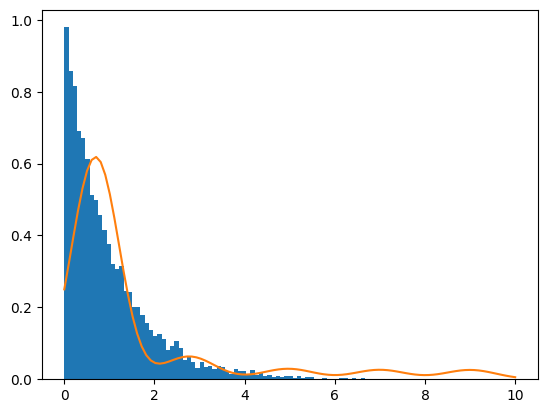

In [3]:
# The approximation we get using SOGA 

from torch.distributions import Exponential

samples = Exponential(1.).sample((10000,))
_ = plt.hist(samples, bins=100, density=True)

program = '''
w = uniform([0,10], 5);
u = uniform([0, 1], 2);
expw = 0 - w;
expw = exp(expw);
observe(u - expw <= 0);
'''

compiledFile = compile2SOGA_text(program)
cfg = produce_cfg_text(compiledFile)
output_dist = start_SOGA(cfg)
marg = extract_marginal(output_dist, ['w'])

x = torch.linspace(0, 10, 100)
y = marg.gm.pdf(x.reshape(-1, 1)).detach().numpy()
plt.plot(x.numpy(), y)

In [4]:
# Programs 

noise_program = '''
w1 = uniform([0,10], 5);
u1 = uniform([0, 1], 2);
expw1 = 0 - w1;
expw1 = exp(expw1);
observe(u1 - expw1 <= 0);   
w2 = uniform([0,10], 5);
u2 = uniform([0, 1], 2);
expw2 = 0 - w2;
expw2 = exp(expw2);
observe(u2 - expw2 <= 0);  
r = w1 + w2;
r = _rate*r;
'''

program = '''
x=gauss(0., 10.);
y=gauss(0., 20.);

r = {};

theta = uniform([0, 6.28], 2);

cosTheta = cos(theta);
xAnon = r*cosTheta;
xAnon = x + xAnon;

sinTheta = sin(theta);
yAnon = r*sinTheta;
yAnon = y + yAnon;
'''


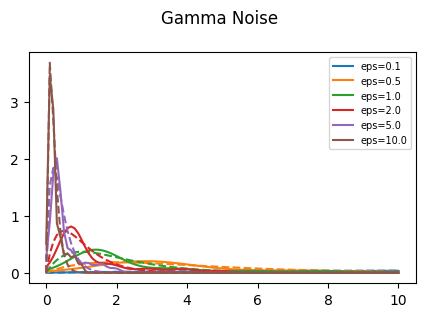

In [5]:
from itertools import cycle

color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

plt.figure(figsize=(5, 3))

for eps in [0.1, 0.5, 1., 2., 5., 10.]:

    x = torch.linspace(0, 10, 100)

    # Computing SOGA approximation
    compiledFile = compile2SOGA_text(noise_program)
    cfg = produce_cfg_text(compiledFile)
    output_dist = start_SOGA(cfg, params_dict={'rate': 1/eps})
    marg = extract_marginal(output_dist, ['r'])
    marg = aggregate_mixture(marg)

    pruned_marg = Dist(marg.var_list, GaussianMix(torch.clone(marg.gm.pi), torch.clone(marg.gm.mu), torch.clone(marg.gm.sigma)))
    pruned_marg = ranking_prune(pruned_marg, 10)

    y_soga = marg.gm.pdf(x.reshape(-1, 1)).detach().numpy()
    y_pruned = pruned_marg.gm.pdf(x.reshape(-1, 1)).detach().numpy()

    # Real density
    y = Gamma(2, eps).log_prob(x).exp().detach().numpy()
    
    color = next(color_cycle)

    plt.plot(x.numpy(), y, ls='--')
    #plt.plot(x.numpy(), y_soga, label='SOGA')
    plt.plot(x.numpy(), y_pruned, color=color, label='eps={}'.format(round(eps,2)))

plt.title('Gamma Noise \n')
#plt.text(3., 4.3, 'Rejection Sampling', ha='center', va='top')
#plt.xlim(0,6)
plt.legend(fontsize=7)

In [11]:
# Computing information separately for x and y

mi_lb_x = {}
mi_ub_x = {}
mi_x = {}

mi_lb_y = {}
mi_ub_y = {}
mi_y = {}

n_samples = 10_000
bounds_time = 0.
sampling_time = 0.

eps_list = torch.tensor([0.1, 0.5, 1., 2., 5., 10.])

for eps in eps_list:

    print('\n Eps: ', eps)

    # creates the noise distribution
    compiledFile = compile2SOGA_text(noise_program)
    cfg = produce_cfg_text(compiledFile)
    noise_dist = start_SOGA(cfg, params_dict={'rate': 1/eps})
    noise_marg = extract_marginal(noise_dist, ['r'])
    noise_marg = aggregate_mixture(noise_marg)
    # prunes the noise distribution
    pruned_noise_marg = Dist(noise_marg.var_list, GaussianMix(torch.clone(noise_marg.gm.pi), torch.clone(noise_marg.gm.mu), torch.clone(noise_marg.gm.sigma)))
    pruned_noise_marg = ranking_prune(pruned_noise_marg, 10)
    gm_str = from_gm_to_string(pruned_noise_marg.gm)

    # adds the noise distribution to the program
    formatted_program = program.format(gm_str)
    compiledFile=compile2SOGA_text(formatted_program)
    cfg = produce_cfg_text(compiledFile)

    # computes the output of the program without observations
    output_dist = start_SOGA(cfg, params_dict={})
    x_marg_dist = extract_marginal(output_dist, ['x', 'xAnon'])
    y_marg_dist = extract_marginal(output_dist, ['y', 'yAnon'])
    x_marg_dist = aggregate_mixture(x_marg_dist)   
    y_marg_dist = aggregate_mixture(y_marg_dist)

    # Computes bounds    
    mi_lb_x['{}'.format(eps)] = mi_lb(x_marg_dist, idx_o=[1])
    mi_ub_x['{}'.format(eps)] = mi_ub(x_marg_dist, idx_o=[1])
    mi_lb_y['{}'.format(eps)] = mi_lb(y_marg_dist, idx_o=[1])
    mi_ub_y['{}'.format(eps)] = mi_ub(y_marg_dist, idx_o=[1])

    # Computes values with MCMC
    mi_x['{}'.format(eps)] = sample_mi(x_marg_dist, idx_o=[1], n_samples=n_samples)
    mi_y['{}'.format(eps)] = sample_mi(y_marg_dist, idx_o=[1], n_samples=n_samples)
    
print('Bounds time: {:.2f} seconds'.format(bounds_time))
print('Sampling time: {:.2f} seconds'.format(sampling_time))

print('\n X axis')
for eps in eps_list:
    print('\t Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(eps), mi_lb_x['{}'.format(eps)], mi_x['{}'.format(eps)], mi_ub_x['{}'.format(eps)]))
    
print('\n Y axis')
for eps in eps_list:
    print('\t Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(eps), mi_lb_y['{}'.format(eps)], mi_y['{}'.format(eps)], mi_ub_y['{}'.format(eps)]))
    


 Eps:  tensor(0.1000)

 Eps:  tensor(0.5000)

 Eps:  tensor(1.)

 Eps:  tensor(2.)

 Eps:  tensor(5.)

 Eps:  tensor(10.)
Bounds time: 0.00 seconds
Sampling time: 0.00 seconds

 X axis
	 Eps = 0.1, lb = 0.000000, exact=0.040257, ub= 2.596838
	 Eps = 0.5, lb = 0.000000, exact=1.120218, ub= 3.808523
	 Eps = 1.0, lb = 0.000000, exact=1.810023, ub= 4.346956
	 Eps = 2.0, lb = 0.498097, exact=2.463071, ub= 5.047398
	 Eps = 5.0, lb = 1.417153, exact=3.393904, ub= 5.965600
	 Eps = 10.0, lb = 2.110692, exact=4.085602, ub= 6.658597

 Y axis
	 Eps = 0.1, lb = 0.000000, exact=0.098740, ub= 2.574910
	 Eps = 0.5, lb = 0.000000, exact=1.457806, ub= 4.004994
	 Eps = 1.0, lb = 0.862847, exact=2.199935, ub= 4.670866
	 Eps = 2.0, lb = 1.635176, exact=2.906198, ub= 5.393623
	 Eps = 5.0, lb = 2.577937, exact=3.840170, ub= 6.320699
	 Eps = 10.0, lb = 3.274820, exact=4.570434, ub= 7.013472


In [5]:
vdelta_rej_lb = {}
vdelta_rej_ub = {}
vgauss_rej_lb = {}
vgauss_rej_ub = {}
vdelta_rej = {}
vgauss_rej = {}

cond_ent_rej_lb = {}
cond_ent_rej_ub = {}
cond_ent_rej = {}

mi_rej_lb = {}
mi_rej_ub = {}
mi_rej = {}

kl_rej_lb = {}
kl_rej_ub = {}
kl_rej = {}

n_samples = 10_000
bounds_time = 0.
sampling_time = 0.

eps_list = torch.tensor([0.1, 0.5, 1., 2., 5., 10.])


for eps in eps_list:

    print('\n Eps: ', eps)

    # creates the noise distribution
    compiledFile = compile2SOGA_text(noise_program)
    cfg = produce_cfg_text(compiledFile)
    noise_dist = start_SOGA(cfg, params_dict={'rate': 1/eps})
    noise_marg = extract_marginal(noise_dist, ['r'])
    noise_marg = aggregate_mixture(noise_marg)
    # prunes the noise distribution
    pruned_noise_marg = Dist(noise_marg.var_list, GaussianMix(torch.clone(noise_marg.gm.pi), torch.clone(noise_marg.gm.mu), torch.clone(noise_marg.gm.sigma)))
    pruned_noise_marg = ranking_prune(pruned_noise_marg, 10)
    gm_str = from_gm_to_string(pruned_noise_marg.gm)

    # adds the noise distribution to the program
    formatted_program = program.format(gm_str)
    compiledFile=compile2SOGA_text(formatted_program)
    cfg = produce_cfg_text(compiledFile)

    # creates a second program with observations
    program_obs = formatted_program + '\n observe(xAnon==10.);\n observe(yAnon==10.);'
    compiledFile=compile2SOGA_text(program_obs)
    cfg_obs = produce_cfg_text(compiledFile)

    # computes the output of the program without observations
    output_dist = start_SOGA(cfg, params_dict={})
    marg_dist = extract_marginal(output_dist, ['x', 'y', 'xAnon', 'yAnon'])
    marg_dist = aggregate_mixture(marg_dist)    
    s_marg = extract_marginal(marg_dist, ['x', 'y'])
    s_marg = aggregate_mixture(s_marg)

    # output of the program with observations
    output_dist_obs = start_SOGA(cfg_obs, params_dict={})
    s_marg_obs = extract_marginal(output_dist_obs, ['x', 'y'])
    s_marg_obs = aggregate_mixture(s_marg_obs)

    # Computes bounds
    start = time()
    vdelta_rej_lb['{}'.format(eps)] = vdelta_lower_bound(marg_dist, idx_o=[2,3], mvariate=True)
    vdelta_rej_ub['{}'.format(eps)] = vdelta_upper_bound(marg_dist, idx_o=[2,3], mvariate=True)
    vgauss_rej_lb['{}'.format(eps)] = vgauss_lower_bound(marg_dist, idx_o=[2,3], eps=1., mvariate=True)
    vgauss_rej_ub['{}'.format(eps)] = vgauss_upper_bound(marg_dist, idx_o=[2,3], eps=1., mvariate=True)

    cond_ent_rej_lb['{}'.format(eps)] = cond_entropy_lb(marg_dist, idx_o=[2,3])
    cond_ent_rej_ub['{}'.format(eps)] = cond_entropy_ub(marg_dist, idx_o=[2,3])
    
    mi_rej_lb['{}'.format(eps)] = mi_lb(marg_dist, idx_o=[2,3])
    mi_rej_ub['{}'.format(eps)] = mi_ub(marg_dist, idx_o=[2,3])

    kl_rej_lb['{}'.format(eps)] = kl_div_lb(s_marg_obs, s_marg)
    kl_rej_ub['{}'.format(eps)] = kl_div_ub(s_marg_obs, s_marg)
    end = time()
    print('Eps = {} took {} seconds to compute bounds'.format(eps, end-start))
    bounds_time += end - start

    # Computes values with MCMC
    start = time()
    vdelta_rej['{}'.format(eps)] = sample_gvuln_multivariate(marg_dist, n_samples=100, secret_var=['x', 'y'], output_var=['xAnon', 'yAnon'], gain_type='delta', num_steps=10, min_samples=5, lr=0.001)
    vgauss_rej['{}'.format(eps)] = sample_gvuln_multivariate(marg_dist, n_samples=100, secret_var=['x', 'y'], output_var=['xAnon', 'yAnon'], gain_type='gauss', num_steps=10, min_samples=5, lr=0.001)

    cond_ent_rej['{}'.format(eps)] = sample_cond_entropy(marg_dist, idx_o=[2,3], n_samples=n_samples)
    mi_rej['{}'.format(eps)] = sample_mi(marg_dist, idx_o=[2,3], n_samples=n_samples)
    kl_rej['{}'.format(eps)] = sample_kl(s_marg_obs, s_marg, n_samples=n_samples)
    end = time()
    print('Eps = {} took {} seconds to compute sampling'.format(eps, end-start))
    sampling_time += end - start
    
print('Bounds time: {:.2f} seconds'.format(bounds_time))
print('Sampling time: {:.2f} seconds'.format(sampling_time))
    


 Eps:  tensor(0.1000)
Eps = 0.10000000149011612 took 2.678083896636963 seconds to compute bounds
Returning after 5 samples
Total time for conditioning: 0.01s
Total time for maximizing: 16.67s
Returning after 5 samples
Total time for conditioning: 0.01s
Total time for maximizing: 8.11s
Eps = 0.10000000149011612 took 29.24280309677124 seconds to compute sampling

 Eps:  tensor(0.5000)
Eps = 0.5 took 1.7026097774505615 seconds to compute bounds
Returning after 5 samples
Total time for conditioning: 0.01s
Total time for maximizing: 15.57s
Returning after 5 samples
Total time for conditioning: 0.01s
Total time for maximizing: 7.55s
Eps = 0.5 took 26.50246262550354 seconds to compute sampling

 Eps:  tensor(1.)
Eps = 1.0 took 0.7266111373901367 seconds to compute bounds
Returning after 5 samples
Total time for conditioning: 0.01s
Total time for maximizing: 8.33s
Returning after 5 samples
Total time for conditioning: 0.01s
Total time for maximizing: 4.81s
Eps = 1.0 took 14.564283609390259 se

In [6]:
print('Delta Gain')
for key in vdelta_rej_lb.keys():
    print('\t Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), vdelta_rej_lb[key], vdelta_rej[key], vdelta_rej_ub[key]))

print('\n Gauss Gain')
for key in vgauss_rej_lb.keys():
    print('\t Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), vgauss_rej_lb[key], vgauss_rej[key], vgauss_rej_ub[key]))

print('\n Conditional Entropy')
for key in cond_ent_rej_lb.keys():
    print('\t Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), cond_ent_rej_lb[key], cond_ent_rej[key], cond_ent_rej_ub[key]))

print('\n Mutual Information')
for key in mi_rej_lb.keys():
    print('\t Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), mi_rej_lb[key], mi_rej[key], mi_rej_ub[key]))

print('\n KL Divergence')
for key in kl_rej_lb.keys():
    print('\t Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), kl_rej_lb[key], kl_rej[key], kl_rej_ub[key]))



Delta Gain
	 Eps = 0.1, lb = 0.000240, exact=0.000921, ub= 0.000953
	 Eps = 0.5, lb = 0.009514, exact=0.019610, ub= 0.035455
	 Eps = 1.0, lb = 0.054081, exact=0.100940, ub= 0.208801
	 Eps = 2.0, lb = 0.245035, exact=0.454842, ub= 0.967521
	 Eps = 5.0, lb = 1.593420, exact=3.006678, ub= 6.349662
	 Eps = 10.0, lb = 6.408563, exact=11.454371, ub= 25.586628

 Gauss Gain
	 Eps = 0.1, lb = 0.001497, exact=0.005764, ub= 0.005943
	 Eps = 0.5, lb = 0.048103, exact=0.102544, ub= 0.172110
	 Eps = 1.0, lb = 0.141548, exact=0.316042, ub= 0.480605
	 Eps = 2.0, lb = 0.212290, exact=0.597638, ub= 0.731728
	 Eps = 5.0, lb = 0.242936, exact=0.854007, ub= 0.912719
	 Eps = 10.0, lb = 0.247941, exact=0.949178, ub= 0.971537

 Conditional Entropy
	 Eps = 0.1, lb = 5.061343, exact=7.984879, ub= 10.569422
	 Eps = 0.5, lb = 2.405334, exact=5.455769, ub= 7.193388
	 Eps = 1.0, lb = 1.104434, exact=4.028307, ub= 5.392240
	 Eps = 2.0, lb = -0.323201, exact=2.621352, ub= 3.917206
	 Eps = 5.0, lb = -2.171536, exact=0

In [7]:
print('Delta Gain')
for key in vdelta_rej_lb.keys():
    print('\t DIR Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), vdelta_noloop_lb[key], vdelta_noloop[key], vdelta_noloop_ub[key]))
    print('\t REJ Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), vdelta_rej_lb[key], vdelta_rej[key], vdelta_rej_ub[key]))
    print('_______________________')

print('\n Gauss Gain')
for key in vgauss_rej_lb.keys():
    print('\t DIR Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), vgauss_noloop_lb[key], vgauss_noloop[key], vgauss_noloop_ub[key]))
    print('\t REJ Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), vgauss_rej_lb[key], vgauss_rej[key], vgauss_rej_ub[key]))
    print('_______________________')

print('\n Conditional Entropy')
for key in cond_ent_rej_lb.keys():
    print('\t DIR Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), cond_ent_noloop_lb[key], cond_ent_noloop[key], cond_ent_noloop_ub[key]))
    print('\t REJ Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), cond_ent_rej_lb[key], cond_ent_rej[key], cond_ent_rej_ub[key]))
    print('_______________________')    

print('\n Mutual Information')
for key in mi_rej_lb.keys():
    print('\t DIR Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), mi_noloop_lb[key], mi_noloop[key], mi_noloop_ub[key]))
    print('\t REJ Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), mi_rej_lb[key], mi_rej[key], mi_rej_ub[key]))
    print('_______________________')

print('\n KL Divergence')
for key in kl_rej_lb.keys():
    print('\t DIR Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), kl_noloop_lb[key], kl_noloop[key], kl_noloop_ub[key]))
    print('\t REJ Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), kl_rej_lb[key], kl_rej[key], kl_rej_ub[key]))
    print('_______________________')


Delta Gain
	 DIR Eps = 0.1, lb = 0.001467, exact=0.002031, ub= 0.002943
	 REJ Eps = 0.1, lb = 0.000240, exact=0.000921, ub= 0.000953
_______________________
	 DIR Eps = 0.5, lb = 0.021571, exact=0.029134, ub= 0.044539
	 REJ Eps = 0.5, lb = 0.009514, exact=0.019610, ub= 0.035455
_______________________
	 DIR Eps = 1.0, lb = 0.081921, exact=0.106518, ub= 0.182266
	 REJ Eps = 1.0, lb = 0.054081, exact=0.100940, ub= 0.208801
_______________________
	 DIR Eps = 2.0, lb = 0.345504, exact=0.490739, ub= 0.691051
	 REJ Eps = 2.0, lb = 0.245035, exact=0.454842, ub= 0.967521
_______________________
	 DIR Eps = 5.0, lb = 1.837116, exact=3.010174, ub= 3.674484
	 REJ Eps = 5.0, lb = 1.593420, exact=3.006678, ub= 6.349662
_______________________
	 DIR Eps = 10.0, lb = 10.099828, exact=15.090132, ub= 20.200558
	 REJ Eps = 10.0, lb = 6.408563, exact=11.454371, ub= 25.586628
_______________________

 Gauss Gain
	 DIR Eps = 0.1, lb = 0.009048, exact=0.012578, ub= 0.018147
	 REJ Eps = 0.1, lb = 0.001497, 

## Approximation 

#### configuration 1

In [2]:
noise_program = '''
w1 = uniform([0,10], 5);
u1 = uniform([0, 1], 2);
expw1 = 0 - w1;
expw1 = exp(expw1);
observe(u1 - expw1 <= 0);   
w2 = uniform([0,10], 5);
u2 = uniform([0, 1], 2);
expw2 = 0 - w2;
expw2 = exp(expw2);
observe(u2 - expw2 <= 0);  
r = w1 + w2;
r = _rate*r;
'''


<Figure size 500x300 with 0 Axes>

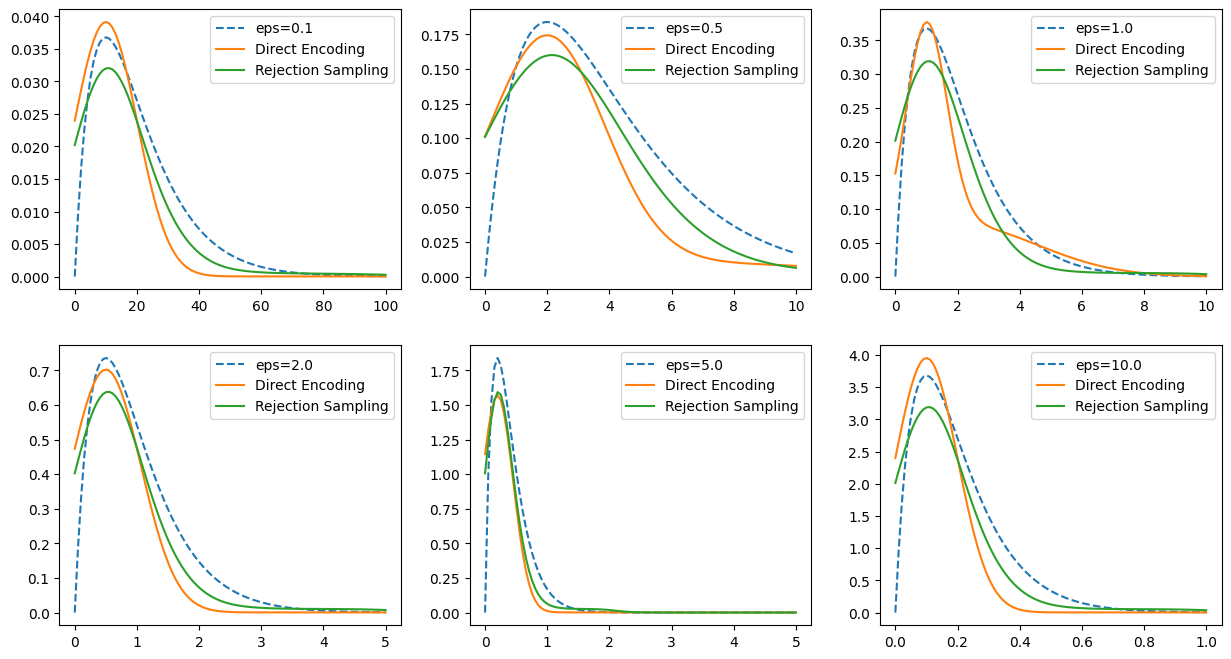

In [4]:
import matplotlib.pyplot as plt
from itertools import cycle

eps_list = torch.tensor([0.1, 0.5, 1., 2., 5., 10.])

color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

plt.figure(figsize=(5, 3))

mean = torch.tensor(2.)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, eps in enumerate(eps_list):

    if i == 0:
        x = torch.linspace(0, 100, 100)
    elif i < 3:
        x = torch.linspace(0, 10, 100)
    elif i < 5: 
        x = torch.linspace(0, 5, 100)
    else:
        x = torch.linspace(0, 1, 100)

### SOGA DIRECT ENCODING 

    program = 'noise = gm([_p1, _p2], [_mu1, _mu2], [_sigma1, _sigma2]);'
    compiledFile = compile2SOGA_text(program)
    cfg = produce_cfg_text(compiledFile)
    mean = torch.tensor(2.)
    scale = 1/eps
    _, pi1, pi2, mu1, mu2, sigma1, sigma2 = fit_gamma(mean, scale)
    pars = {'p1': pi1,
        'p2': pi2,
        'mu1': mu1,
        'mu2': mu2,
        'sigma1': sigma1,
        'sigma2': sigma2
        }
    params_dict = {}
    for key, value in pars.items():
        params_dict[key] = torch.tensor(value.item(), requires_grad=True)    
    output_dist = start_SOGA(cfg, params_dict=params_dict)

    y_soga_direct = output_dist.gm.pdf(x.reshape(-1, 1)).detach().numpy()

### SOGA REJECTION SAMPLING

    compiledFile = compile2SOGA_text(noise_program)
    cfg = produce_cfg_text(compiledFile)
    output_dist = start_SOGA(cfg, params_dict={'rate': 1/eps})
    marg = extract_marginal(output_dist, ['r'])
    marg = aggregate_mixture(marg)

    pruned_marg = Dist(marg.var_list, GaussianMix(torch.clone(marg.gm.pi), torch.clone(marg.gm.mu), torch.clone(marg.gm.sigma)))
    pruned_marg = ranking_prune(pruned_marg, 20)  

    y_soga = marg.gm.pdf(x.reshape(-1, 1)).detach().numpy()
    y_soga_rej = pruned_marg.gm.pdf(x.reshape(-1, 1)).detach().numpy()

    y = Gamma(mean, eps).log_prob(x).exp()

    axes[i].plot(x.numpy(), y.numpy(), ls='--', label='eps={}'.format(round(eps.item(),2)))
    axes[i].plot(x.numpy(), y_soga_direct, label='Direct Encoding')
    axes[i].plot(x.numpy(), y_soga_rej, label='Rejection Sampling')
    axes[i].legend()